<a href="https://colab.research.google.com/github/AriachAmine/VK_Arabic/blob/main/Arabic_VK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
mloey1_ahcd1_path = kagglehub.dataset_download('mloey1/ahcd1')

print('Data source import complete.')

100%|██████████| 24.0M/24.0M [00:00<00:00, 74.2MB/s]

Extracting files...


Data source import complete.


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageDraw, ImageFont
import random
import os

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
import cv2

In [3]:
Train_Images = pd.read_csv(mloey1_ahcd1_path + "/csvTrainImages 13440x1024.csv")
Train_Labels = pd.read_csv(mloey1_ahcd1_path + "/csvTrainLabel 13440x1.csv")

Test_Images = pd.read_csv(mloey1_ahcd1_path + "/csvTestImages 3360x1024.csv")
Test_Labels = pd.read_csv(mloey1_ahcd1_path + "/csvTestLabel 3360x1.csv")

print(f"Train Iamges : {Train_Images.shape} | Train Labels : {Train_Labels.shape}")
print(f"Test  Iamges : {Test_Images.shape} | Test  Labels : {Test_Labels.shape}")

Train Iamges : (13439, 1024) | Train Labels : (13439, 1)
Test  Iamges : (3359, 1024) | Test  Labels : (3359, 1)


In [5]:
arabic_letters = ['ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي']

arabic_punctuations = ["،", "؛", "؟", "!", "...", "«", "»", "”", "“", "(", ")"]

arabic_chars = arabic_letters + arabic_punctuations

In [77]:
!rm -r /content/punctuation_marks

def generate_punctuation_image(punctuation_mark, font_path, image_size=32, variation=0):
    """Generates an image of a punctuation mark with slight variations."""
    img = Image.new('L', (image_size, image_size), color=0)  # 'L' for grayscale
    d = ImageDraw.Draw(img)
    font_size = int(image_size * 0.8)  # Adjust font size
    try:
        font = ImageFont.truetype(font_path, font_size)
    except IOError:
        print(f"Font not found at {font_path}")
        return None

    bbox = d.textbbox((0, 0), punctuation_mark, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]

    # Introduce slight variations in position and size
    x_offset = random.randint(-3, 3)
    size_variation = random.uniform(0.9, 1) * (1 + variation * 0.05)

    x = (image_size - text_width * size_variation) / 2 + x_offset
    y = 2 + size_variation

    d.text((x, y), punctuation_mark, fill=255, font=font, anchor="lt", scale=size_variation)

    # Convert to NumPy array and reshape
    img_array = np.array(img)
    img_array = img_array.reshape(image_size, image_size, 1)

    flipped_img = np.fliplr(img_array)

    img_array = np.rot90(flipped_img, k=1, axes=(0, 1))

    return img_array


# --- Main execution ---
font_path = "/content/font.ttf"
output_dir = "punctuation_marks"

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

punctuation_data = []
punctuation_labels = []

for l, mark in enumerate(arabic_punctuations):
  for i in range(50):
    img_array = generate_punctuation_image(mark, font_path, image_size=32, variation=i)
    if img_array is not None:
        filename = f"{output_dir}/punct({mark}){i}.npy"
        punctuation_data.append(img_array)
        punctuation_labels.append(l + 28)
        try:
            np.save(filename, img_array)  # Save as NumPy array
        except Exception as e:
            print(f"Error saving {filename}: {e}")

punctuation_data = np.array(punctuation_data)
punctuation_labels = np.array(punctuation_labels).reshape(len(punctuation_labels), 1)

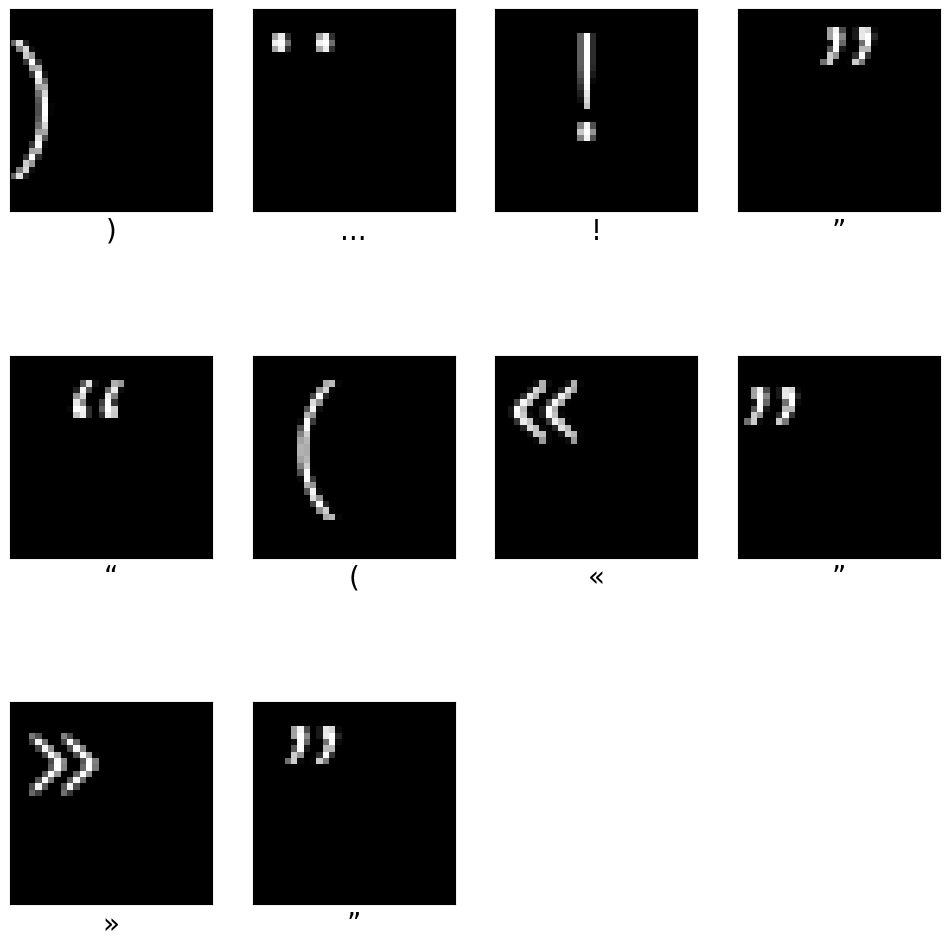

In [83]:
ra = np.random.randint(0, punctuation_data.shape[0], size=11)
filenames = [f for f in os.listdir(output_dir) if f.endswith('.npy')]

plt.figure(figsize=(12, 12))
for i in range(10):
    plt.subplot(3, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(punctuation_data[ra[i]].reshape(32, 32).T, "gray")
    plt.xlabel(arabic_chars[int(punctuation_labels[ra[i]][0])], fontsize=20, color='black', ha='center')
    plt.subplots_adjust(hspace=0.5)
plt.show()

In [84]:
x_train = Train_Images.to_numpy()
y_train = Train_Labels.to_numpy()-1
x_train = x_train.reshape(-1,32,32,1)
x_train = x_train / 255.0

x_test = Test_Images.to_numpy()
x_test  = x_test.reshape(-1,32,32,1)
y_test = Test_Labels.to_numpy()-1
x_test  = x_test / 255.0

print(f"X_Train Shape : {x_train.shape}")
print(f"X_Test  Shape : {x_test.shape}")
print(f"Y_Train Shape : {y_train.shape}")
print(f"Y_Test  Shape : {y_test.shape}")

X_Train Shape : (13439, 32, 32, 1)
X_Test  Shape : (3359, 32, 32, 1)
Y_Train Shape : (13439, 1)
Y_Test  Shape : (3359, 1)


In [85]:
x_train_concat = np.concatenate([x_train, punctuation_data])
y_train_concat = np.concatenate([y_train, punctuation_labels])

x_test_concat = np.concatenate([x_test, punctuation_data])
y_test_concat = np.concatenate([y_test, punctuation_labels])

x_train_concat.shape, y_train_concat.shape

((13989, 32, 32, 1), (13989, 1))

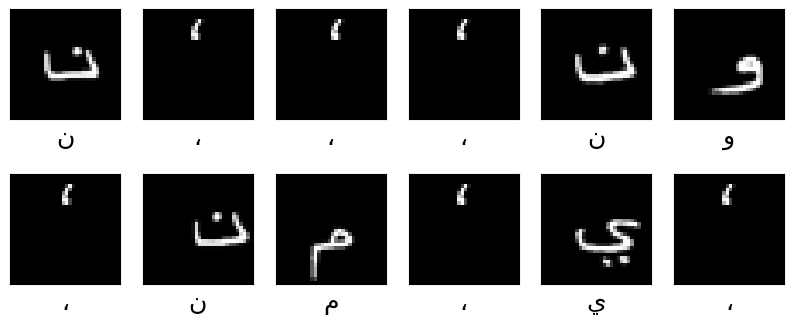

In [91]:
ra = np.random.randint(13400, 13450, size=25)
plt.figure(figsize=(10, 10))
for i in range(12):
    plt.subplot(5, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train_concat[ra[i]].reshape(32, 32).T, "gray")
    plt.xlabel(arabic_chars[int(y_train_concat[ra[i]][0])], fontsize=18, color='black', ha='center')
    plt.subplots_adjust(hspace=0.5)
plt.show()

In [92]:
y_train_concat = to_categorical(y_train_concat)
y_test_concat  = to_categorical(y_test_concat)
print(y_train_concat.shape, y_test_concat.shape)

(13989, 39) (3909, 39)


In [93]:
model = Sequential([
    Input(shape=(32, 32, 1)),

    Conv2D(32, (5, 5), padding="same", activation="relu"),
    Conv2D(32, (5, 5), activation="relu"),
    Conv2D(32, (5, 5), activation="relu"),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (5, 5), padding="same", activation="relu"),
    Conv2D(64, (5, 5), activation="relu"),
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation="relu"),
    Dense(128, activation="relu"),
    Dropout(0.4),

    Dense(39, activation="softmax")
])

opt = Adam(1e-3)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

model.summary()
plot_model(model, show_shapes=True)

In [94]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)
train_gen = datagen.flow(x_train_concat, y_train_concat, batch_size=64)
test_gen  = datagen.flow(x_test_concat, y_test_concat , batch_size=64)

In [95]:
model_checkpoint_callback = ModelCheckpoint(
    filepath="best.keras",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

history = model.fit(
    train_gen,
    epochs=48,
    verbose=1,
    steps_per_epoch=x_train.shape[0] // 64,
    validation_data=test_gen,
    validation_steps=x_test.shape[0] // 64,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/48


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.0650 - loss: 3.4464
Epoch 1: val_accuracy improved from -inf to 0.10968, saving model to best.keras
209/209 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.0652 - loss: 3.4449 - val_accuracy: 0.1097 - val_loss: 2.9215
Epoch 2/48
  8/209 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1915 - loss: 2.4547

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.10968
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2192 - loss: 2.3655 - val_accuracy: 0.0832 - val_loss: 3.2924
Epoch 3/48
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3500 - loss: 1.9362
Epoch 3: val_accuracy improved from 0.10968 to 0.23017, saving model to best.keras
209/209 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.3504 - loss: 1.9348 - val_accuracy: 0.2302 - val_loss: 2.8617
Epoch 4/48
 10/209 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5625 - loss: 1.2434
Epoch 4: val_accuracy improved from 0.23017 to 0.26472, saving model to best.keras
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5774 - loss: 1.2138 - val_accuracy: 0.2647 - val_loss: 2.4594
Epoch 5/48
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6490 - loss: 0.9874
Epoch 5: val_accuracy improved from 0.26472 to 0.41617, saving model to best.keras
209/209 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.6491 - loss: 0.9870 - val_acc

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


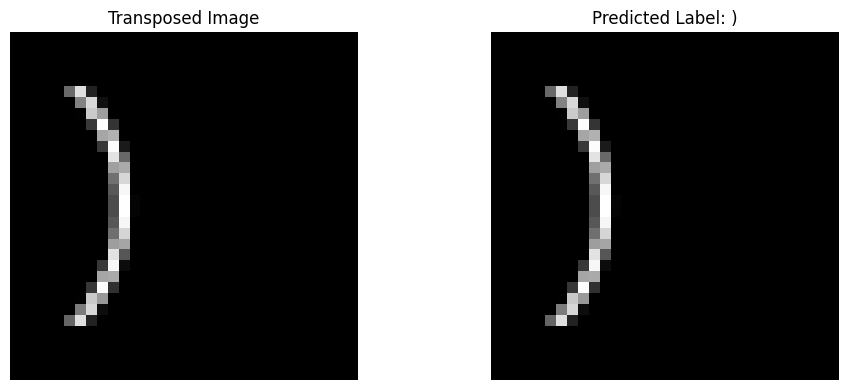

In [107]:
pred = model.predict(x_test_concat)

image_num = -8
predictions = pred[image_num]
predicted_label = arabic_chars[np.argmax(predictions)]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(x_test_concat[image_num].reshape(32, 32).T, cmap='gray')
plt.axis('off')
plt.title('Transposed Image')
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.imshow(x_test_concat[image_num].reshape(32, 32).T, cmap='gray')
plt.title(f'Predicted Label: {predicted_label}')
plt.axis('off')
plt.show()

In [ ]:
def predict_image(image_path, model):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (32, 32))
    img = img.reshape(1, 32, 32, 1)
    img = img.astype('float32') / 255.0

    pred = model.predict(img)
    predicted_label = arabic_chars[np.argmax(pred)]

    return predicted_label

def plot_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

model = load_model('/content/best.keras')
predicted_label = predict_image('/content/test.png', model)
print(f'Predicted Label: {predicted_label}')
plot_image('/content/test.png')